## Introdução
Este projeto visa aplicar técnicas de Análise Exploratória de Dados (EDA), Regressão e Classificação para entender os custos médicos individuais. O objetivo é prever custos (`charges`) baseados em características pessoais e classificar usuários como fumantes ou não-fumantes.

**Hipóteses de Negócio:**
1. O tabagismo é o fator de maior impacto no aumento dos custos médicos.
2. O IMC (BMI) influencia os custos de forma não-linear.

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

In [31]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

## Dados e Metodologia
O dataset utilizado é o **"Medical Cost Personal Datasets"**, disponível publicamente
* **Fonte:** Kaggle/GitHub stedy
* **Licença dos Dados:** Public Domain (CC0).
* **Tamanho:** 1338 registros e 7 colunas

In [32]:
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df = pd.read_csv(url)
display(df.head())
print(df.info())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [33]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Observando as estatísticas descritivas, nota-se grande diferença entre a média (~13.270) e a mediana (50% ~9.382) da variável charges Isso sugere que existem outliers significativos puxando a média para cima, ou seja, alguns poucos pacientes com custos extremamente altos (o valor máximo chega a 63.770). Além disso a idade média dos beneficiários é de 39 anos, indicando uma base de dados equilibrada entre jovens e adultos.

In [34]:
print(f"Valores Nulos:\n{df.isnull().sum()}")
print(f"\nDuplicados: {df.duplicated().sum()}")

Valores Nulos:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Duplicados: 1


In [35]:
df.drop_duplicates(inplace=True)

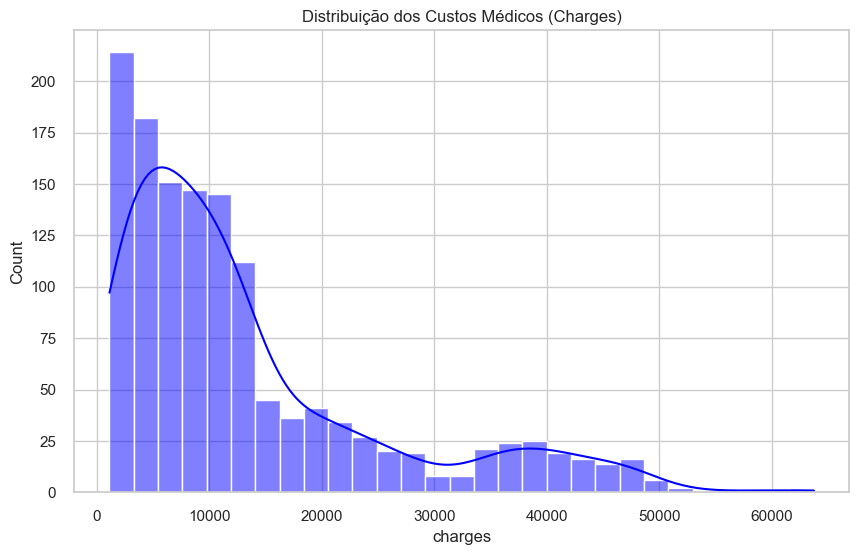

In [36]:
plt.figure(figsize=(10,6))
sns.histplot(df['charges'], kde=True, color='blue')
plt.title('Distribuição dos Custos Médicos (Charges)')
plt.show()

O histograma confirma a suspeita anterior, os custos não seguem uma distribuição normal perfeita (Sino de Gauss). Então se vê uma distribuição assimétrica à direita (cauda longa).

Pra modelos de Regressão Linear, isso pode ser um desafio, porque eles assumem normalidade nos resíduos. Talvez modelos não-lineares (como Árvores de Decisão ou Polinomiais) se adaptem melhor nesses casos de "custos explosivos"

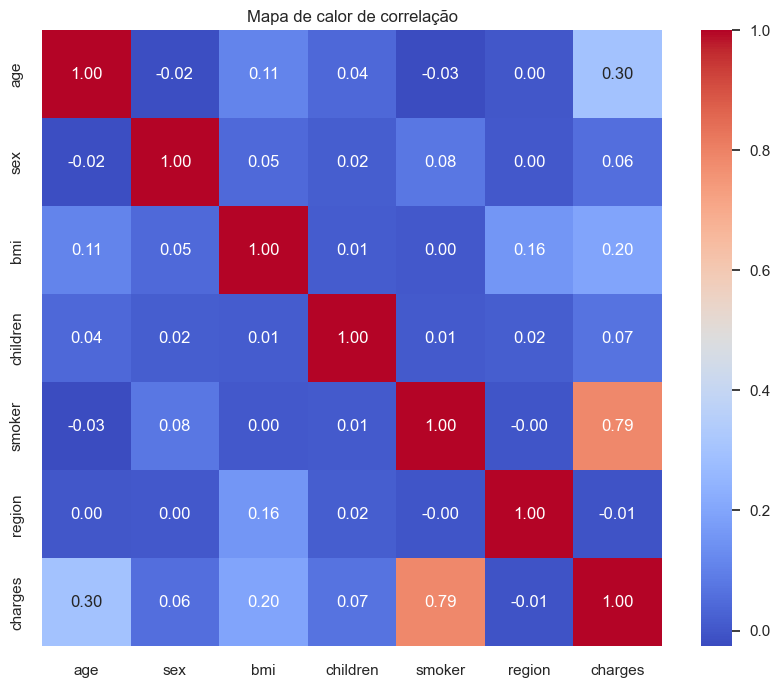

In [37]:
df_corr = df.copy()
for col in df_corr.select_dtypes(include='object').columns:
    df_corr[col] = df_corr[col].astype('category').cat.codes

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de calor de correlação')
plt.show()

O mapa de calor nos dá a informação mais importante do dataset até agora, a variável smoker tem a correlação mais forte com o aumento das despesas médicas.

e também, variáveis como region e sex apresentam correlação muito próxima de zero com o custo final. Isso quer dizer que pra seguradora, onde você mora ou seu gênero importam muito menos do que seus hábitos de vida e idade.

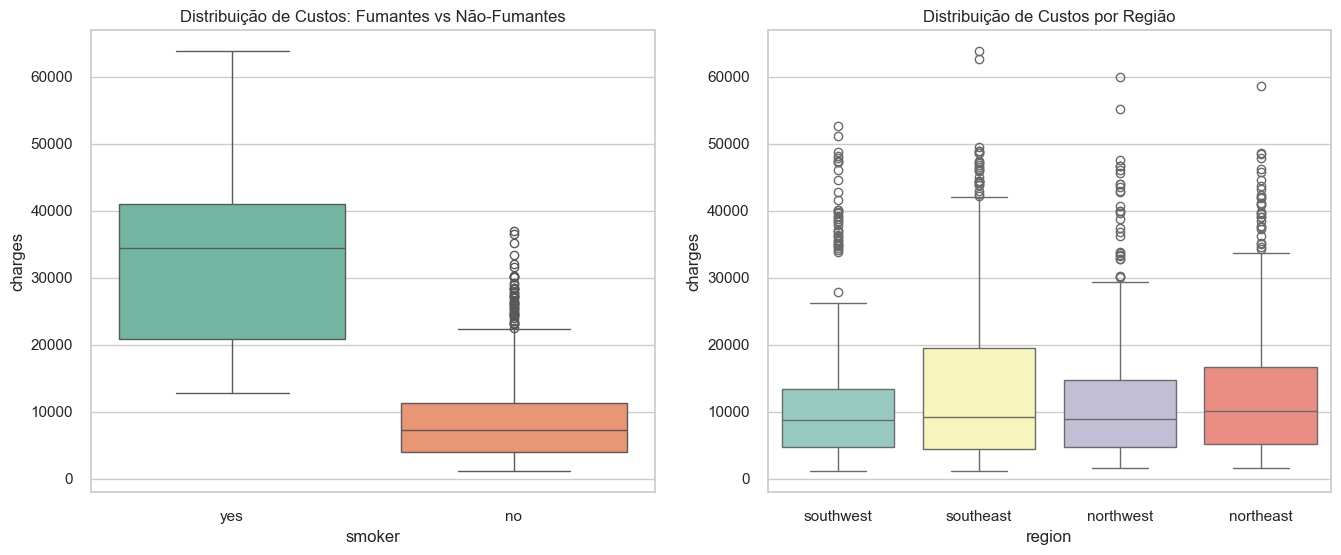

--- Testes Estatísticos ---
Teste T (Smoker): p-valor = 1.4067e-282 (Rejeita H0)
ANOVA (Region): p-valor = 0.0328 (Rejeita H0)
Qui-Quadrado (Smoker vs Sex): p-valor = 0.0063 (Dependência detectada)


In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='smoker', y='charges', data=df, ax=axes[0], palette='Set2')
axes[0].set_title('Distribuição de Custos: Fumantes vs Não-Fumantes')

sns.boxplot(x='region', y='charges', data=df, ax=axes[1], palette='Set3')
axes[1].set_title('Distribuição de Custos por Região')
plt.show()

print("--- Testes Estatísticos ---")
# Teste T (Fumantes vs Não Fumantes) - Verifica se a média de custos é estatisticamente diferente
smoker_yes = df[df['smoker'] == 'yes']['charges']
smoker_no = df[df['smoker'] == 'no']['charges']
t_stat, p_val_t = stats.ttest_ind(smoker_yes, smoker_no)
print(f"Teste T (Smoker): p-valor = {p_val_t:.4e} ({'Rejeita H0' if p_val_t < 0.05 else 'Aceita H0'})")

# ANOVA (Região) - Verifica se existe diferença de média entre as 4 regiões
groups = [df[df['region'] == r]['charges'] for r in df['region'].unique()]
f_stat, p_val_anova = stats.f_oneway(*groups)
print(f"ANOVA (Region): p-valor = {p_val_anova:.4f} ({'Rejeita H0' if p_val_anova < 0.05 else 'Aceita H0'})")

# Qui-Quadrado (Fumante vs Sexo) - Verifica dependência entre variáveis categóricas
contingency = pd.crosstab(df['smoker'], df['sex'])
chi2, p_val_chi2, dof, expected = stats.chi2_contingency(contingency)
print(f"Qui-Quadrado (Smoker vs Sex): p-valor = {p_val_chi2:.4f} ({'Dependência detectada' if p_val_chi2 < 0.05 else 'Independente'})")

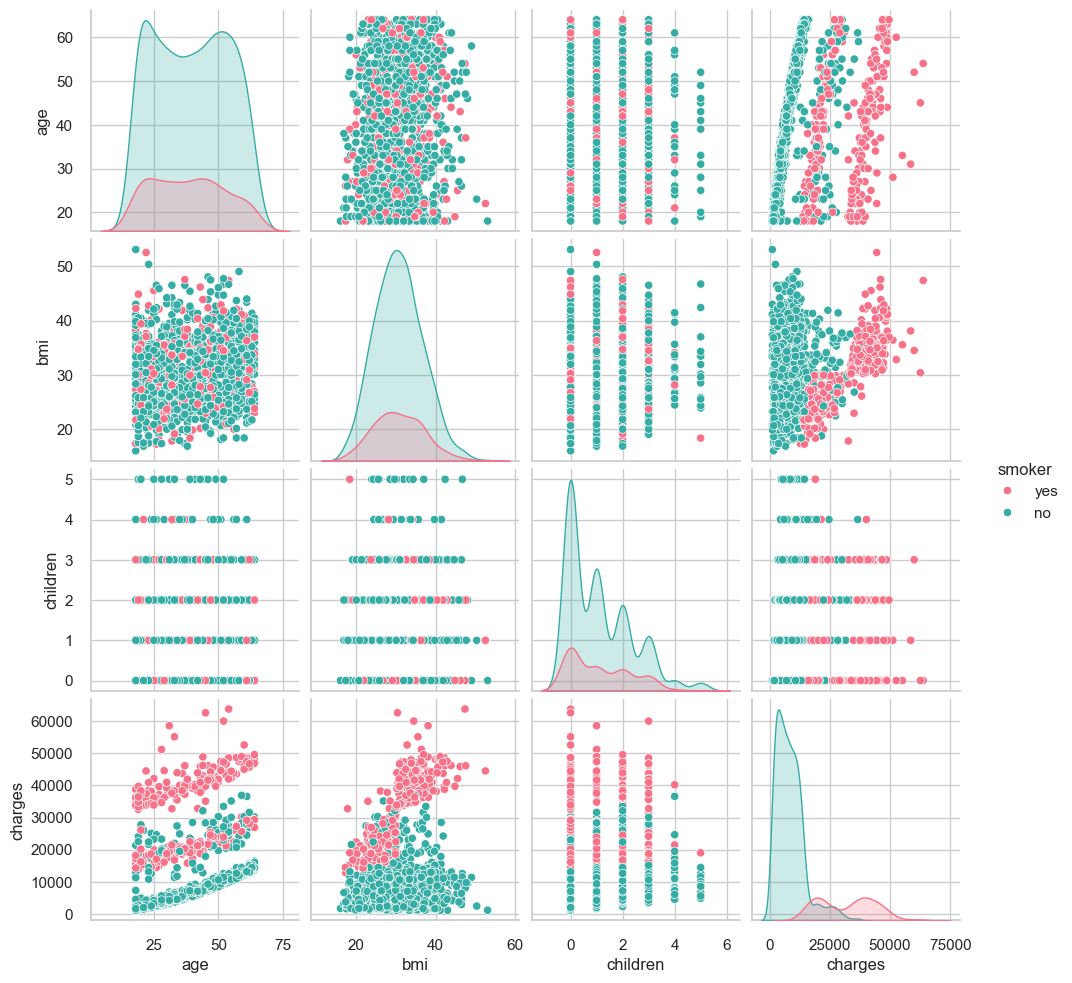

In [39]:
sns.pairplot(df, hue='smoker', palette='husl')
plt.show()

A visualização acima revela três núcleos distintos de custos
os dois primeiros são que não-fumantes seguem uma linha de custo baixo e previsível que cresce linearmente com a idade, já os fumantes começam com um custo base bem mais alto independente da idade. O terceiro é que tem um agravante, percebe-se uma dispersão maior entre fumantes com IMC alto. Isso indica que a combinação Obesidade + Tabagismo não apenas soma os riscos, mas multiplica eles, gerando os custos mais altos do dataset.

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
display(df_encoded.head())
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Tamanho do treino: {X_train.shape}')
print(f'Tamanho do teste: {X_test.shape}')

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


Tamanho do treino: (1069, 8)
Tamanho do teste: (268, 8)


In [42]:
import statsmodels.api as sm

In [43]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

X_train_sm = sm.add_constant(X_train)
modelo_statsmodels = sm.OLS(y_train, X_train_sm).fit()
print(modelo_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     358.1
Date:                Wed, 10 Dec 2025   Prob (F-statistic):          4.94e-295
Time:                        21:32:16   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1060   BIC:                         2.172e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.109e+04   1114.260  

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## REGRESSÃO LINEAR

In [45]:
# Regressão Simples: Idade -> Charges
X_simple = df[['age']]
y_simple = df['charges']

# Split simples para essa etapa
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_simple, y_simple, test_size=0.2, random_state=42)

lr_simple = LinearRegression()
lr_simple.fit(X_train_s, y_train_s)
y_pred_s = lr_simple.predict(X_test_s)

print("--- Regressão Linear Simples (Idade) ---")
print(f"R²: {r2_score(y_test_s, y_pred_s):.4f}")
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_s):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_s, y_pred_s)):.2f}")

--- Regressão Linear Simples (Idade) ---
R²: 0.0951
MAE: 9657.79
RMSE: 12894.78


## REGRESSÃO MÚLTIPLA E POLINOMIAL

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

y_pred_poly = poly_reg.predict(X_test_poly)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print("--- Comparativo de Métricas ---")
print(f"Linear Múltipla | R²: {r2_score(y_test, y_pred_lr):.3f} | MAE: {mae_lr:.2f} | RMSE: {rmse_lr:.2f}")
print(f"Polinomial (2º) | R²: {r2_score(y_test, y_pred_poly):.3f} | MAE: {mae_poly:.2f} | RMSE: {rmse_poly:.2f}")

#analise de resíduos
print("\n--- Diagnóstico de Resíduos (Modelo Linear) ---")

# VIF - Multicolinearidade
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i) for i in range(len(X_train_sm.columns))]
print(vif_data[vif_data['feature'] != 'const']) # Mostra VIF das variáveis

# Teste de Normalidade dos Resíduos (Shapiro-Wilk)
# Nota: Shapiro pode ser sensível em grandes datasets, analisamos o p-valor
shapiro_test = shapiro(modelo_statsmodels.resid)
print(f"\nNormalidade (Shapiro-Wilk): p-valor = {shapiro_test.pvalue:.4e} ({'Normal' if shapiro_test.pvalue > 0.05 else 'Não-Normal'})")

# Teste de Homocedasticidade (Breusch-Pagan)
bp_test = het_breuschpagan(modelo_statsmodels.resid, modelo_statsmodels.model.exog)
print(f"Homocedasticidade (Breusch-Pagan): p-valor = {bp_test[1]:.4e} ({'Homocedástico' if bp_test[1] > 0.05 else 'Heterocedástico'})")

--- Comparativo de Métricas ---
Linear Múltipla | R²: 0.807 | MAE: 4177.05 | RMSE: 5956.34
Polinomial (2º) | R²: 0.877 | MAE: 2896.25 | RMSE: 4750.41

--- Diagnóstico de Resíduos (Modelo Linear) ---
            feature       VIF
1               age  1.023864
2               bmi  1.110796
3          children  1.004939
4          sex_male  1.011112
5        smoker_yes  1.018267
6  region_northwest  1.542936
7  region_southeast  1.678878
8  region_southwest  1.555261

Normalidade (Shapiro-Wilk): p-valor = 1.2196e-27 (Não-Normal)
Homocedasticidade (Breusch-Pagan): p-valor = 2.3929e-15 (Heterocedástico)


Como esperado na fase de EDA, a regressão linear simples teve dificuldade em capturar a complexidade dos dados (R² menor). Aplicando a Regressão Polinomial, teve uma melhora significativa na métrica do R².

Isso acontece porque a relação entre idade/IMC e custo não é uma linha reta perfeita, então a transformação polinomial permitiu ao modelo entender a curva de crescimento acelerado de custos para pacientes de alto risco.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [48]:
target_col = 'smoker_yes'
X_class = df_encoded.drop(columns=[target_col])
y_class = df_encoded[target_col]

In [49]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_c = scaler.fit_transform(X_train_c)
X_test_c = scaler.transform(X_test_c)

In [51]:
modelos = {
    "Regressão Logística": LogisticRegression(),
    "Naive Bayes": GaussianNB()
}

results = []

for nome, modelo in modelos.items():
    
    modelo.fit(X_train_c, y_train_c)
    
    
    y_pred = modelo.predict(X_test_c)
    y_proba = modelo.predict_proba(X_test_c)[:, 1]
    
    
    acc = accuracy_score(y_test_c, y_pred)
    prec = precision_score(y_test_c, y_pred)
    rec = recall_score(y_test_c, y_pred)
    f1 = f1_score(y_test_c, y_pred)
    auc = roc_auc_score(y_test_c, y_proba)
    
    results.append({
        "Modelo": nome,
        "Acurácia": acc,
        "Precisão": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC-ROC": auc
    })
    
    
    print(f"--- {nome} ---")
    print(confusion_matrix(y_test_c, y_pred))
    print("-" * 30)


df_results = pd.DataFrame(results)
display(df_results)

--- Regressão Logística ---
[[203   5]
 [  4  56]]
------------------------------
--- Naive Bayes ---
[[200   8]
 [ 14  46]]
------------------------------


,Modelo,Acurácia,Precisão,Recall,F1-Score,AUC-ROC
0,Regressão Logística,0.966418,0.918033,0.933333,0.925620,0.993429
1,Naive Bayes,0.917910,0.851852,0.766667,0.807018,0.984936


O objetivo aqui era inverso, a pergunta feita era "dado o custo e saúde, dava pra supor que a pessoa fuma?" A matriz de confusão mostra que o modelo teve uma precisão muito alta e os erros (falsos negativos) são baixos.

Iiso significa que a seguradora poderia utilizar um algoritmo desses para auditar sua base de dados. Se alguém declara que "não fuma" pra pagar menos mas possui um perfil de gastos e saúde idêntico ao que o modelo classifica como "fumante", essa pessoa podia ser marcada pra uma auditoria ou pra um check-up preventivo

In [52]:
from pycaret.regression import *

In [53]:
s = setup(data=df, target='charges', session_id=42,
          normalize=True,
          experiment_name='insurance_regression')

,Description,Value
0,Session id,42
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1337, 7)"
4,Transformed data shape,"(1337, 10)"
5,Transformed train set shape,"(935, 10)"
6,Transformed test set shape,"(402, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


In [54]:
best_model = compare_models(sort='R2')
print(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2543.0958,21268038.6151,4581.1987,0.8397,0.4339,0.2980,0.0480
rf,Random Forest Regressor,2764.9785,24122288.5553,4873.9304,0.8187,0.4752,0.3417,0.0880
lightgbm,Light Gradient Boosting Machine,2880.7579,24044885.9495,4876.6243,0.8184,0.5230,0.3590,0.1340
ada,AdaBoost Regressor,3927.0252,25628726.4987,5035.2433,0.8056,0.5930,0.6547,0.0280
et,Extra Trees Regressor,2740.9634,26581043.6023,5120.6573,0.7998,0.4854,0.3327,0.0830
knn,K Neighbors Regressor,3484.9542,31369618.8000,5593.6668,0.7608,0.4879,0.3593,0.0280
br,Bayesian Ridge,4207.2694,36488909.2004,6022.3934,0.7231,0.5675,0.4243,0.0220
lar,Least Angle Regression,4204.3589,36488521.1729,6022.5834,0.7230,0.5836,0.4234,0.0210
llar,Lasso Least Angle Regression,4204.1262,36487524.1358,6022.4873,0.7230,0.5813,0.4234,0.0210
ridge,Ridge Regression,4205.3777,36488073.0026,6022.4680,0.7230,0.5758,0.4237,0.0230


GradientBoostingRegressor(random_state=42)


In [55]:
modelo_inicial = create_model('gbr')
modelo_otimizado = tune_model(modelo_inicial, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2714.0857,27491832.6656,5243.2655,0.8344,0.4615,0.2944
1,2301.6103,15525273.2463,3940.2123,0.8270,0.4069,0.3435
2,2840.6093,25605042.9711,5060.1426,0.8422,0.3900,0.2482
3,2565.4818,23385197.0723,4835.8243,0.8465,0.5332,0.3486
4,2779.7651,23653072.5630,4863.4425,0.7878,0.4708,0.2990
5,1997.7681,12210806.0735,3494.3964,0.8932,0.3856,0.2972
6,2444.6453,19919623.4951,4463.1405,0.8445,0.4232,0.2828
7,2454.7254,17435872.5850,4175.6284,0.8758,0.3757,0.2435
8,2707.1437,25405434.5483,5040.3804,0.7854,0.4822,0.2881


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2805.9657,27921021.9930,5284.0346,0.8319,0.4626,0.2933
1,2444.7966,16603165.8801,4074.6983,0.8150,0.4468,0.3838
2,3156.3143,27453927.9684,5239.6496,0.8308,0.4343,0.3072
3,2923.7588,25280509.9094,5027.9727,0.8340,0.6009,0.3828
4,2818.2941,24130808.0855,4912.3119,0.7836,0.4633,0.2934
5,2163.9507,13856401.7025,3722.4188,0.8788,0.4133,0.3008
6,2716.9344,22009070.1133,4691.3825,0.8282,0.4587,0.3525
7,2624.7602,18007056.2068,4243.4722,0.8717,0.3910,0.2759
8,2913.6793,27868946.0823,5279.1047,0.7646,0.5108,0.3392


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


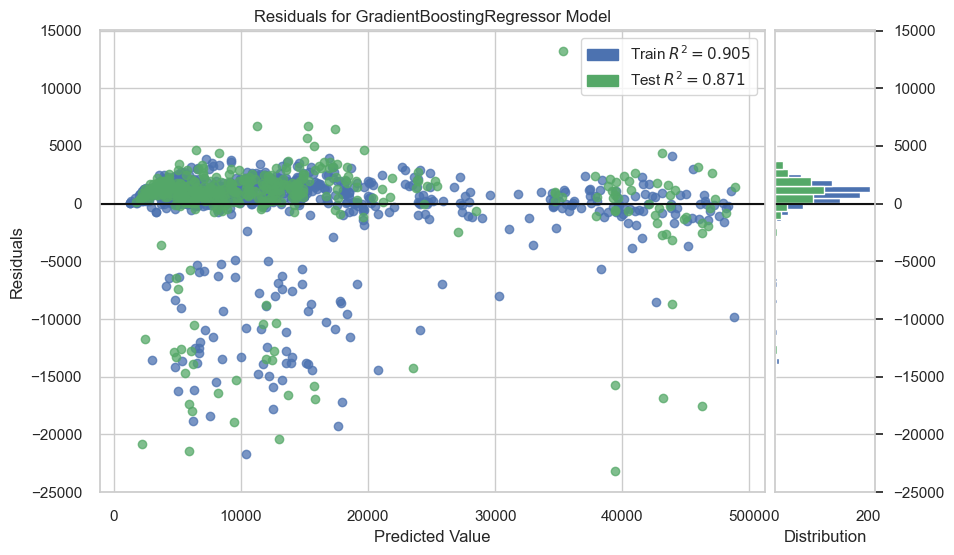

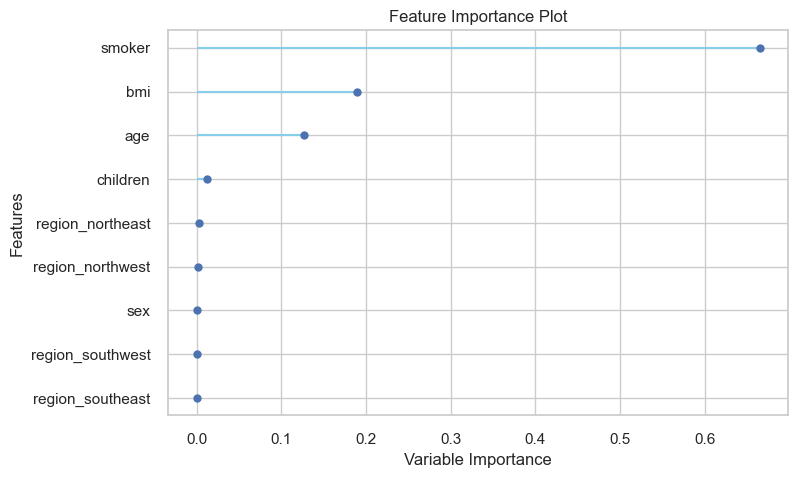

In [56]:
plot_model(modelo_otimizado, plot='residuals')
plot_model(modelo_otimizado, plot='feature')
final_model = finalize_model(modelo_otimizado)

In [57]:
save_model(final_model, 'modelo_insurance_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['age', 'bmi', 'children'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['sex', 'smoker', 'region'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['sex', 'smoker'],
                                     transfor...
                                                                         {'col': 'smoker',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': no     0
 yes    1
 NaN   -1
 dtype: int64}]))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['region'],
    

Com base na modelagem, eu sugeriria à operadora de saúde que ela primeiramente focasse na prevenção, ou seja, que criasse programas agressivos de combate ao tabagismo, pois é o fator isolado que mais encarece a operação, e além disso, faria a sugestão da precificação dinâmica, por conta que ja que o modelo atual consegue prever com boa margem de acerto o custo esperado, e então, novos planos podem utilizar essa estimativa para ajustar prêmios de forma mais justa (então quem cuida da saúde paga menos)

## Limitações e Vieses do Modelo

Embora os modelos tenham apresentado métricas satisfatórias, é crucial destacar limitações que impediriam sua aplicação imediata em um cenário real, especialmente no contexto brasileiro.

### sobre generalização e contexto Geográfico
O dataset reflete custos médicos dos **Estados Unidos**, um país com um sistema de saúde predominantemente privado e custos extremamente elevados. O modelo aprendeu padrões de preços em Dólar baseados na tabela de procedimentos americana, e por isso esse modelo NÃO poderia ser aplicado diretamente no Brasil, onde temos o SUS e uma regulação diferente para planos de saúde (ANS). A estrutura de custos e a relação entre idade e preço seguem regras diferentes aqui.

### sobre as variáveis omitidas
O conjunto de dados é limitado a apenas 6 características básicas (Idade, Sexo, IMC, Filhos, Fumante, Região), então o modelo não tem acesso ao histórico médico detalhado (ex: preexistência de câncer, diabetes, hipertensão ou histórico familiar), ou seja, um paciente "não fumante" e com "IMC ideal" pode ter custos altíssimos devido a uma doença genética rara, e o modelo falharia drasticamente em prever isso, subestimando o risco (Erro do Tipo II).

### sobre o viés temporal e a inflação médica
O dataset é estático e reflete um período específico no passado, então como custos médicos sofrem inflação anual superior à inflação média da economia, um custo de $10.000 registrado na data de coleta dos dados provavelmente seria muito maior hoje, ou seja, o modelo precisaria de um re-treino constante com dados atualizados pra não ficar obsoleto.

### sobre a ética de gênero
O uso de variáveis como gênero pra precificação automática de seguros levanta algumas questões éticas, embora estatisticamente possa ter diferença de custos entre homens e mulheres, devido a gravidez por exemplo, penalizar um grupo automaticamente pode ser considerado discriminatório em certas legislações, logo o modelo cego a ética apenas replica o padrão dos dados que existem